In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import os, cv2, re, random, time, zipfile, gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import layers, models, optimizers
#from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam
import efficientnet.tfkeras as efn


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


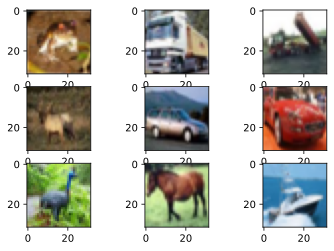

In [4]:
# example of loading the cifar10 dataset
from matplotlib import pyplot
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

In [5]:

from tensorflow.keras.utils import to_categorical
# one hot encode target values
trainY = to_categorical(trainy)
testY = to_categorical(testy)
trainY

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:

# convert from integers to floats
train_norm = trainX.astype('float32')
test_norm = testX.astype('float32')
test_norm

array([[[[158., 112.,  49.],
         [159., 111.,  47.],
         [165., 116.,  51.],
         ...,
         [137.,  95.,  36.],
         [126.,  91.,  36.],
         [116.,  85.,  33.]],

        [[152., 112.,  51.],
         [151., 110.,  40.],
         [159., 114.,  45.],
         ...,
         [136.,  95.,  31.],
         [125.,  91.,  32.],
         [119.,  88.,  34.]],

        [[151., 110.,  47.],
         [151., 109.,  33.],
         [158., 111.,  36.],
         ...,
         [139.,  98.,  34.],
         [130.,  95.,  34.],
         [120.,  89.,  33.]],

        ...,

        [[ 68., 124., 177.],
         [ 42., 100., 148.],
         [ 31.,  88., 137.],
         ...,
         [ 38.,  97., 146.],
         [ 13.,  64., 108.],
         [ 40.,  85., 127.]],

        [[ 61., 116., 168.],
         [ 49., 102., 148.],
         [ 35.,  85., 132.],
         ...,
         [ 26.,  82., 130.],
         [ 29.,  82., 126.],
         [ 20.,  64., 107.]],

        [[ 54., 107., 160.],
       

In [19]:
import tensorflow as tf
model = models.Sequential()


efnModel = efn.EfficientNetB0(weights = 'imagenet', 
                       input_shape = (224, 224,3), 
                       include_top = False,
                       classes=10)
model.add(efnModel)
model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Dense(512, activation= 'relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='sigmoid'))

# decay is included for backward compatibility to allow time inverse decay of lr
opt = Adam(lr=1e-4) 

model.compile(loss='categorical_crossentropy',
              optimizer = opt, 
              metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 4,020,358
Non-trainable params: 42,016
_________________________________________________________________


In [20]:
trainY

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
datagen = ImageDataGenerator(
            rescale=1. / 255,             # Scale data to 0-1 range
            )          # How to fill in newly created pixels

val_datagen = ImageDataGenerator(rescale=1./255)
import tensorflow as tf
with tf.device('/device:GPU:1'):
    BATCH_SIZE = 16
    datagen = datagen.flow(train_norm, trainY, batch_size=BATCH_SIZE)
    val_datagen = val_datagen.flow(test_norm, testY, batch_size=BATCH_SIZE)

    earlystop1 = EarlyStopping(patience=5)
    earlystop2 = ReduceLROnPlateau(monitor = 'val_accuracy', min_lr = 0.001, 
                                patience = 5, mode = 'min', 
                                verbose = 1)

    history = model.fit(datagen, 
                        steps_per_epoch=45,
                        epochs=40,
                        validation_data=val_datagen,
                        callbacks=[earlystop1, earlystop2],
                        validation_steps=25)

    model.save('cifar_10_efficientnetb0.h5')

Epoch 1/40
45/45 [==============================] - 11s 143ms/step - loss: 2.6489 - accuracy: 0.1153 - val_loss: 2.3698 - val_accuracy: 0.0975 - lr: 1.0000e-04
Epoch 2/40
45/45 [==============================] - 6s 127ms/step - loss: 2.3917 - accuracy: 0.1681 - val_loss: 2.3471 - val_accuracy: 0.1300 - lr: 1.0000e-04
Epoch 3/40
45/45 [==============================] - 6s 128ms/step - loss: 2.3181 - accuracy: 0.1917 - val_loss: 2.3138 - val_accuracy: 0.1525 - lr: 1.0000e-04
Epoch 4/40
45/45 [==============================] - 6s 128ms/step - loss: 2.1920 - accuracy: 0.2236 - val_loss: 2.2492 - val_accuracy: 0.1900 - lr: 1.0000e-04
Epoch 5/40
45/45 [==============================] - 6s 128ms/step - loss: 2.1102 - accuracy: 0.2569 - val_loss: 2.1327 - val_accuracy: 0.2375 - lr: 1.0000e-04
Epoch 6/40
45/45 [==============================] - 6s 128ms/step - loss: 2.0001 - accuracy: 0.2931 - val_loss: 1.9684 - val_accuracy: 0.2950 - lr: 1.0000e-04
Epoch 7/40
45/45 [===========================

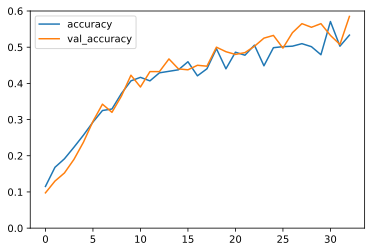

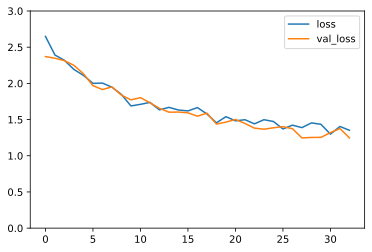

In [32]:
plt.rcParams['figure.facecolor'] = 'white'
model_loss = pd.DataFrame(history.history)
model_loss.head()
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,0.6]);
model_loss[['loss','val_loss']].plot(ylim=[0,3]);

In [34]:
test = []
for img in test_images:
    test.append(cv2.resize(cv2.imread(img), 
                        (IMG_WIDTH, IMG_HEIGHT), 
                        interpolation=cv2.INTER_CUBIC))
test = np.array(test)
test


array([[[[ 22,  24,  32],
         [ 29,  31,  39],
         [ 18,  20,  28],
         ...,
         [119, 110, 107],
         [118, 109, 106],
         [114, 105, 102]],

        [[ 54,  56,  64],
         [ 47,  49,  57],
         [ 28,  30,  38],
         ...,
         [119, 110, 107],
         [118, 109, 106],
         [117, 108, 105]],

        [[ 43,  45,  53],
         [ 49,  51,  59],
         [ 37,  39,  47],
         ...,
         [117, 110, 107],
         [116, 109, 106],
         [114, 107, 104]],

        ...,

        [[ 67,  78,  86],
         [ 60,  77,  91],
         [ 61,  82,  99],
         ...,
         [112, 110, 110],
         [117, 114, 115],
         [145, 142, 144]],

        [[ 70,  82,  87],
         [ 75,  87, 101],
         [ 79,  91, 110],
         ...,
         [111, 107, 108],
         [116, 114, 114],
         [144, 143, 146]],

        [[ 69,  81,  86],
         [ 82,  95, 108],
         [ 80,  92, 112],
         ...,
         [103, 105, 110],
        

In [35]:
test = test.astype('float32') / 255
test_pred = np.where(model.predict(test)>0.5,1,0)
submission = pd.DataFrame({'id': range(1, len(test_images) + 1), 'label': test_pred.ravel()})
submission.to_csv('submission.csv', index = False)
submission

,id,label
0,1,0
1,2,1
2,3,0
3,4,1
4,5,0
...,...,...
495,496,0
496,497,1
497,498,0
498,499,0
